In [1]:
import xarray as xr
from datetime import datetime

import torch

from aurora import AuroraSmall, Batch, Metadata, rollout
import matplotlib.pyplot as plt

from pathlib import Path

import cdsapi
import numpy as np
from sklearn.metrics import root_mean_squared_error
import gcsfs

from torch.utils.data import Dataset
from aurora import Batch, Metadata
import os

torch.use_deterministic_algorithms(True)

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


/home/koomi_aims_ac_za/koomi/projects/AIMS-PROJECT/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

In [3]:
import sys
sys.path.append(os.path.abspath("../src"))
from utils import get_surface_feature_target_data, get_atmos_feature_target_data
from utils import get_static_feature_target_data, create_batch, predict_fn, rmse_weights
from utils import rmse_fn, plot_rmses, create_hrest0_batch

In [4]:
from evaluation import evaluation
from lora import create_custom_model, full_linear_layer_lora


# Data

In [5]:

fs = gcsfs.GCSFileSystem(token="anon")

store = fs.get_mapper('gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr')
full_era5 = xr.open_zarr(store=store, consolidated=True, chunks=None)



# start_time, end_time = '2022-11-01', '2023-01-31'
start_time, end_time = '2022-01-01', '2022-01-03' #'2021-12-31'
# start_time, end_time = '2023-01-08', '2023-01-31'



lat_max = -22.00 
lat_min = -37.75  

lon_min = 15.25   
lon_max = 35.00   
sliced_era5_SA = (
    full_era5
    .sel(
        time=slice(start_time, end_time),
        latitude=slice(lat_max, lat_min),
        longitude=slice(lon_min, lon_max)  
    )
)

################################"" get hres data
store_hrest0 = fs.get_mapper('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr')
full_hrest0 = xr.open_zarr(store=store_hrest0, consolidated=True, chunks=None)
sliced_hrest0_sa = full_hrest0.sel(time=slice(start_time, end_time), 
                                   latitude=slice(lat_min, lat_max), 
                                   longitude=slice(lon_min, lon_max))



# Models

In [6]:
model_initial = AuroraSmall(
    use_lora=False,  # fine_tuned_Model was not fine-tuned.
)

model_initial.load_state_dict(torch.load('../model/urora-0.25-small-pretrained1.pth'))


<All keys matched successfully>

# Model 1

In [7]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = create_custom_model(fine_tuned_model, lora_r = 8, lora_alpha = 1)
# checkpoint = torch.load('../model/training/hrest0/checkpoint_epoch_6.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Model 2

In [8]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 8, lora_alpha = 1)
# checkpoint = torch.load('../model/training/hrest0/model2/checkpoint_epoch_5.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Model 3

In [9]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/model3/checkpoint_epoch_7.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Model 4

In [10]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/model4/checkpoint_epoch_5.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Model 5

In [11]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/model5/checkpoint_epoch_11.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Model 6

In [12]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/model6/checkpoint_epoch_9.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Model 7

In [13]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/model7/checkpoint_epoch_7.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Lats1 relative lost

In [14]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/last1/checkpoint_epoch_6.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Lats2 with initial weights

In [15]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/last2/checkpoint_epoch_1.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

In [16]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/wampln/checkpoint_epoch_7.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# DEterministic first

In [17]:
# fine_tuned_model = AuroraSmall(
#     use_lora=False,  
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/deterministic/checkpoint_epoch_3.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

# Deterministic Backbone

In [18]:
fine_tuned_model = AuroraSmall(
    use_lora=False,  
)
fine_tuned_model = create_custom_model(fine_tuned_model, lora_r = 16, lora_alpha = 2)
checkpoint = torch.load('../model/training/hrest0/backbone2/checkpoint_epoch_7.pth')

fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:

results = evaluation(fine_tuned_model, model_initial, sliced_era5_SA, sliced_hrest0_sa)

2025-05-31 04:49:53,658 - INFO - Evaluation completed


In [20]:
counter = results['counter']
surface_rmses_fine_tuned = results['surface_rmses_fine_tuned']
atmospheric_rmses_fine_tuned = results['atmospheric_rmses_fine_tuned']
surface_rmses_non_fine_tuned = results['surface_rmses_non_fine_tuned']
atmospheric_rmses_non_fine_tuned = results['atmospheric_rmses_non_fine_tuned']

# Relative Loss

## Surface variables

In [21]:
relative_surface_rmses = {}

In [22]:
for surf_var, rmses in surface_rmses_fine_tuned.items():
    
    relative_surface_rmses[surf_var] = (surface_rmses_fine_tuned[surf_var]-surface_rmses_non_fine_tuned[surf_var])/surface_rmses_non_fine_tuned[surf_var]*100
    

In [23]:
relative_surface_rmses

{'2t': array([1142.21801255, 1273.61094889, 1216.91301677, 1003.06508257,
         693.46584972,  635.56365994,  721.7147374 ,  534.04818361]),
 '10u': array([168.20939644, 121.41176456, 110.52684758, 113.72303134,
        146.71844189, 185.0164232 , 190.40091484, 116.37395972]),
 '10v': array([124.30199971,  73.53505399,  59.67200339,  49.85953124,
         73.52039352,  78.76789771,  67.95396736,  41.66614975]),
 'msl': array([337.1570843 , 327.19116249, 186.98771811, 231.31577972,
        164.33463552, 191.73888303, 101.79077735,  56.8646439 ])}

## Atmospheric variables

In [24]:
relative_atmospheric_rmses = {}

In [25]:
for atmos_var, rmses in atmospheric_rmses_fine_tuned.items():
    
    relative_atmospheric_rmses[atmos_var] = (atmospheric_rmses_fine_tuned[atmos_var]-atmospheric_rmses_non_fine_tuned[atmos_var])/atmospheric_rmses_non_fine_tuned[atmos_var]*100
    

# Plots

In [26]:
import seaborn as sns

## Surface variables

In [27]:

# # Create scatter plots for each variable with 'Region' as hue
# plt.figure(figsize=(15, 15))  # Adjust figure size as needed
# for i, variable in enumerate(atmospheric_rmses_fine_tuned):
#     plt.subplot(5, 5, i + 1) 
#     sns.heatmap(relative_atmospheric_rmses[variable], cmap="RdBu_r", cbar=True)
#     plt.xlabel("Lead Time (Hours)")
#     plt.ylabel("")
#     plt.title(f"{variable}")
#     plt.yticks(np.arange(0.5, 13, 1), [50, 60, 70, 100, 150, 160,  200, 500, 600, 700, 800, 900, 1000])  
#     plt.xticks(np.arange(0.5,8.5,1), np.arange(6, 48+6, 6))  fine_tuned_model = AuroraSmall(
#     use_lora=False,  # fine_tuned_Model was not fine-tuned.
#     autocast=True,  # Use AMP.
#     stabilise_level_agg=True
# )
# fine_tuned_model = full_linear_layer_lora(fine_tuned_model, lora_r = 16, lora_alpha = 4)
# checkpoint = torch.load('../model/training/hrest0/model4/checkpoint_epoch_5.pth')

# fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])
# plt.tight_layout()
# plt.show()


In [28]:

# # Create scatter plots for each variable with 'Region' as hue
# plt.figure(figsize=(15, 0.4))  # Adjust figure size as needed
# for i, variable in enumerate(surface_rmses_fine_tuned):
#     plt.subplot(4, 4, i + 1) 
#     sns.heatmap(relative_surface_rmses[variable].reshape(1,-1), cmap="RdBu_r", cbar=False)
#     plt.xlabel("Lead Time (Hours)")
#     plt.ylabel("")
#     plt.title(f"{variable}")
#     plt.yticks([])  
#     plt.xticks(np.arange(0.5,8.5,1), np.arange(6, 48+6, 6))  
# # plt.tight_layout()
# plt.show();




In [29]:
# cbar.set_label("Relative RMSE", fontsize=12)


/var/tmp/ipykernel_1264960/456227532.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


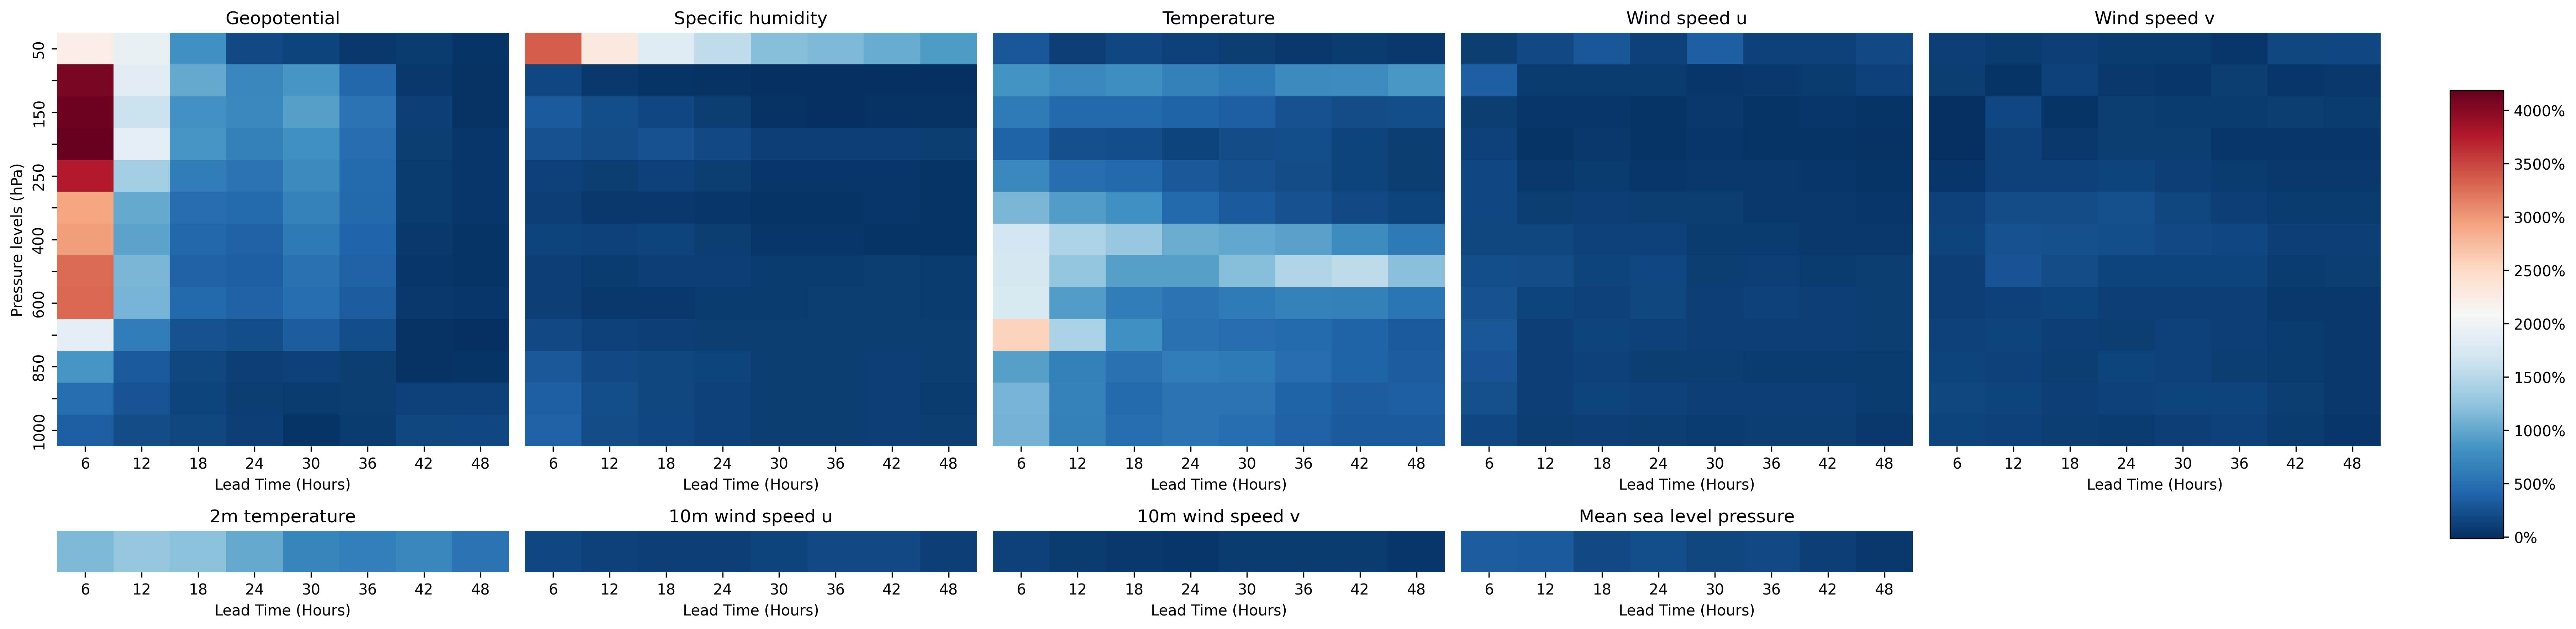

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter  # <-- Add this import

surface_variables_names = ["2m temperature", "10m wind speed u", "10m wind speed v", "Mean sea level pressure"]
atmospheric_variables_names = ["Geopotential", "Specific humidity", "Temperature", "Wind speed u", "Wind speed v"]

num_atmospheric = len(atmospheric_rmses_fine_tuned)
num_surface = len(surface_rmses_fine_tuned)
n_cols = 5

# Compute global vmin and vmax for color consistency
all_values = np.concatenate(
    [relative_atmospheric_rmses[var].flatten() for var in atmospheric_rmses_fine_tuned] +
    [relative_surface_rmses[var].flatten() for var in surface_rmses_fine_tuned]
)
vmin, vmax = np.min(all_values), np.max(all_values)

# Create the figure and gridspec layout with space for vertical colorbar
fig = plt.figure(figsize=(25, 6), dpi=300)
gs = GridSpec(2, n_cols, height_ratios=[1, 0.1], figure=fig)

# Plot atmospheric heatmaps
for i, variable in enumerate(atmospheric_rmses_fine_tuned):
    ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
    sns.heatmap(relative_atmospheric_rmses[variable], cmap="RdBu_r", cbar=False, vmin=vmin, vmax=vmax, ax=ax)
    ax.set_xlabel("Lead Time (Hours)")
    if i % n_cols == 0:
        ax.set_ylabel("Pressure levels (hPa)")
        ax.set_yticks(np.arange(0.5, 13, 1))  # Keep all ticks
        full_labels = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
        # Remove some labels (e.g., show only every 2nd one)
        cleaned_labels = [label if idx % 2 == 0 else "" for idx, label in enumerate(full_labels)]
        ax.set_yticklabels(cleaned_labels)

    else:
        ax.set_yticks([])
    ax.set_title(f"{atmospheric_variables_names[i]}")
    ax.set_xticks(np.arange(0.5, 8.5, 1))
    ax.set_xticklabels(np.arange(6, 48+6, 6))

# Plot surface heatmaps
for j, variable in enumerate(surface_rmses_fine_tuned):
    ax = fig.add_subplot(gs[1, j])
    sns.heatmap(relative_surface_rmses[variable].reshape(1, -1), cmap="RdBu_r", cbar=False, vmin=vmin, vmax=vmax, ax=ax)
    ax.set_xlabel("Lead Time (Hours)")
    ax.set_ylabel("")
    ax.set_title(f"{surface_variables_names[j]}")
    ax.set_yticks([])
    ax.set_xticks(np.arange(0.5, 8.5, 1))
    ax.set_xticklabels(np.arange(6, 48+6, 6))

# Add a vertical colorbar on the right side with percentage formatting
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)

# Format colorbar tick labels as percentages
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}%"))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [31]:
relative_atmospheric_rmses["v"].max()

np.float64(267.1448835175742)

In [32]:
vmin

np.float64(-14.10547823061828)

/var/tmp/ipykernel_1264960/1374544501.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


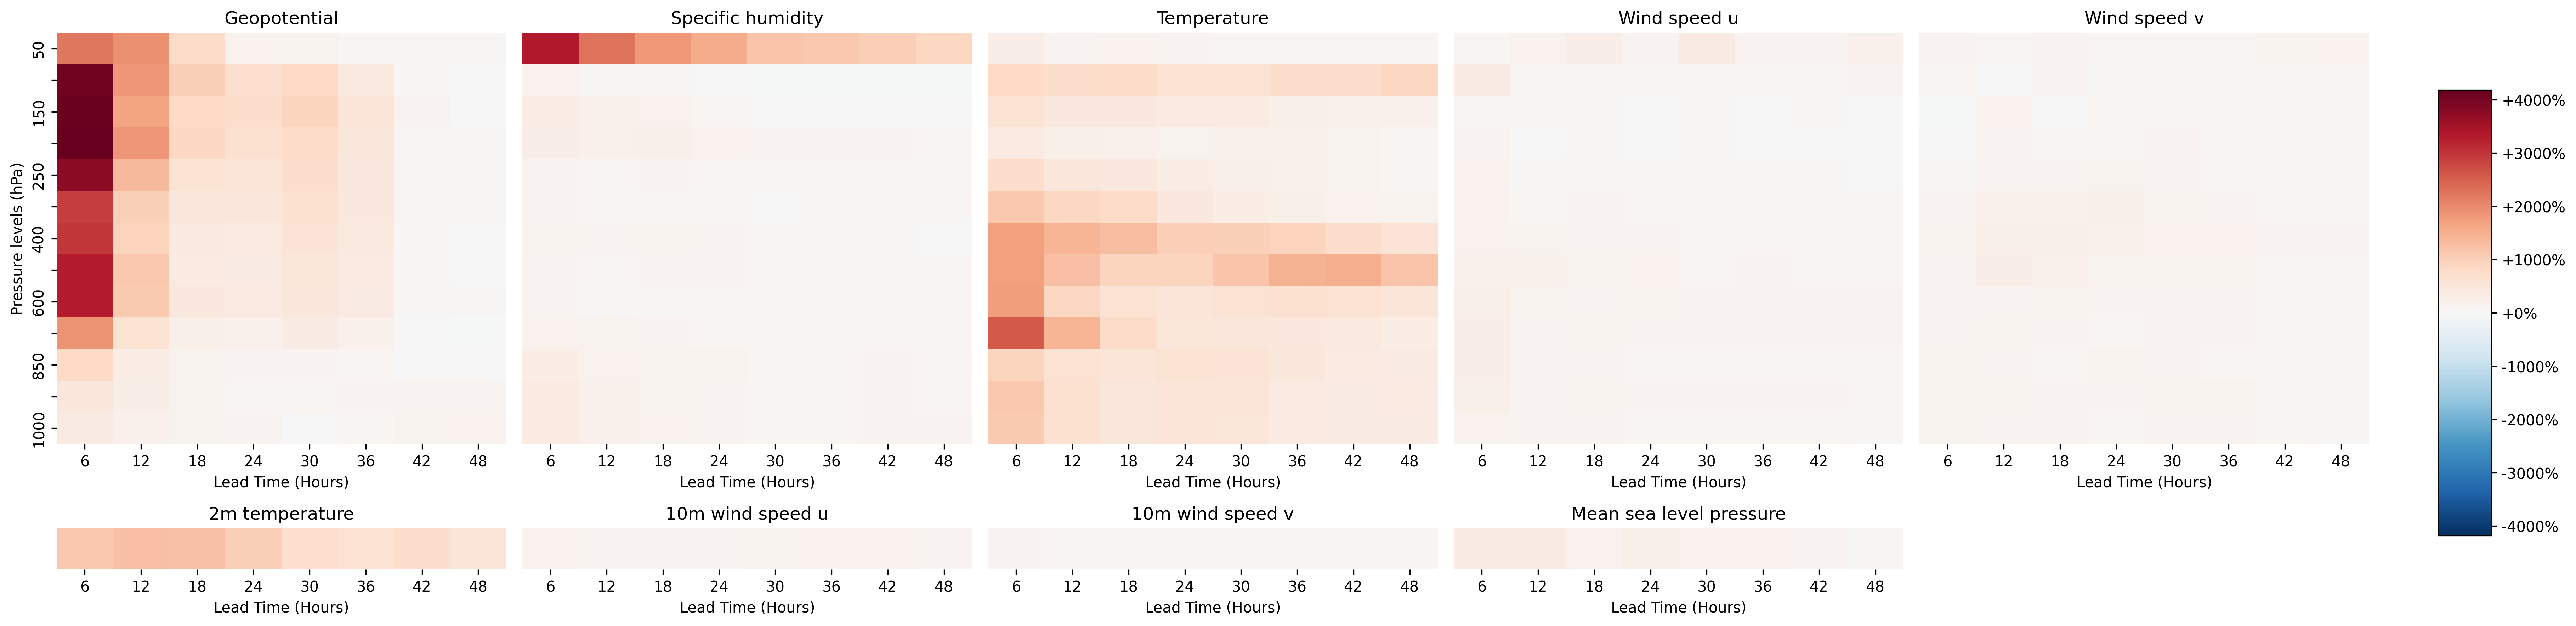

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import TwoSlopeNorm

# relative_surface_rmses["2t"][0]=-20

# Example dummy data to avoid errors if you run this without defining them
# Remove or replace this block with your actual data
# surface_variables_names = ["2m temperature", "10m wind speed u", "10m wind speed v", "Mean sea level pressure"]
# atmospheric_variables_names = ["Geopotential", "Specific humidity", "Temperature", "Wind speed u", "Wind speed v"]

# # Dummy variable keys and data — replace with your actual ones
# atmospheric_rmses_fine_tuned = atmospheric_variables_names
# surface_rmses_fine_tuned = surface_variables_names

# relative_atmospheric_rmses = {var: np.random.uniform(-20, 20, (13, 8)) for var in atmospheric_rmses_fine_tuned}
# relative_surface_rmses = {var: np.random.uniform(-20, 20, 8) for var in surface_rmses_fine_tuned}

# Compute global vmin and vmax for color consistency
all_values = np.concatenate(
    [relative_atmospheric_rmses[var].flatten() for var in atmospheric_rmses_fine_tuned] +
    [relative_surface_rmses[var].flatten() for var in surface_rmses_fine_tuned]
)
vmin, vmax = np.min(all_values), np.max(all_values)
abs_max = max(abs(vmin), abs(vmax))
# Create a norm centered at 0
norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

# Create the figure and gridspec layout with space for vertical colorbar
fig = plt.figure(figsize=(25, 6), dpi=300)
n_cols = 5
gs = GridSpec(2, n_cols, height_ratios=[1, 0.1], figure=fig)

# Plot atmospheric heatmaps
for i, variable in enumerate(atmospheric_rmses_fine_tuned):
    ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
    sns.heatmap(relative_atmospheric_rmses[variable], cmap="RdBu_r", cbar=False, norm=norm, ax=ax)
    ax.set_xlabel("Lead Time (Hours)")
    if i % n_cols == 0:
        ax.set_ylabel("Pressure levels (hPa)")
        ax.set_yticks(np.arange(0.5, 13, 1))
        full_labels = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
        cleaned_labels = [label if idx % 2 == 0 else "" for idx, label in enumerate(full_labels)]
        ax.set_yticklabels(cleaned_labels)
    else:
        ax.set_yticks([])
    ax.set_title(f"{atmospheric_variables_names[i]}")
    ax.set_xticks(np.arange(0.5, 8.5, 1))
    ax.set_xticklabels(np.arange(6, 48+6, 6))

# Plot surface heatmaps
for j, variable in enumerate(surface_rmses_fine_tuned):
    ax = fig.add_subplot(gs[1, j])
    sns.heatmap(relative_surface_rmses[variable].reshape(1, -1), cmap="RdBu_r", cbar=False, norm=norm, ax=ax)
    ax.set_xlabel("Lead Time (Hours)")
    ax.set_ylabel("")
    ax.set_title(f"{surface_variables_names[j]}")
    ax.set_yticks([])
    ax.set_xticks(np.arange(0.5, 8.5, 1))
    ax.set_xticklabels(np.arange(6, 48+6, 6))

# Add vertical colorbar on the right side
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)

# Format colorbar ticks with +/- signs and percent
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:+.0f}%"))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [34]:
vmin

np.float64(-14.10547823061828)

In [35]:
vmax

np.float64(4185.592551823611)

In [36]:
len(np.where(all_values<=0)[0])

6

In [37]:
len(np.where(all_values>0)[0])

546